In [1]:
import pandas as pd
data = pd.read_csv("C:\\Users\\olake\\Desktop\\PROJETS_CAS_ENTREPRISE\\PROJET_1\\data\\donnees_nettoy\\livres_final.csv")

## VECTORISATION

Il faut transformer le texte en vecteurs numériques pour que les modèles puissent travailler dessus.

In [2]:
data = data.dropna(subset=["avis_nettoy"])

In [24]:
stopwords_clusters = {
    "life", "just", "love", "writing", "character",
    "book", "novel", "way", "reading", "like",
    "time", "read", "story"
}

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import spacy

nlp = spacy.load("en_core_web_sm")  # modèle anglais
english_stopwords = set(nlp.Defaults.stop_words)
stopwords = list(english_stopwords.union(stopwords_clusters))

# Création du vectorizer
vectorizer = TfidfVectorizer(max_features = 10000,max_df = 0.8, min_df = 5, ngram_range=(1,2), stop_words=stopwords)

# Transformation du texte
X_tfidf = vectorizer.fit_transform(data["avis_nettoy"])


c:\Users\olake\Desktop\PROJETS_CAS_ENTREPRISE\PROJET_1\venv\Lib\site-packages\sklearn\feature_extraction\text.py:411: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


# ANALYSE THEMATIQUE

Je veux regrouper les avis par thèmes :

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

data['cluster'] = clusters
data[['avis_nettoy', 'cluster']].head()

,avis_nettoy,cluster
0,gentle reminder time read book reread 2017 don...,3
1,60 star know risking film 11 moment club upsid...,3
2,looking new book dont want commit check latest...,3
3,pick kill mockingbird instantly visited sensor...,4
4,longer review written book comment sadly annoy...,3


Je veux voir les mots les plus importants de chaque cluster :

In [33]:
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(5):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print()

Cluster 0:
 dickens
 mr
 woolf
 jane
 austen
 virginia
 woman
 jane austen
 virginia woolf
 dalloway

Cluster 1:
 world
 woman
 man
 war
 family
 people
 year
 work
 young
 end

Cluster 2:
 written
 work
 great
 good
 interesting
 author
 year
 page
 think
 end

Cluster 3:
 dont
 thing
 know
 think
 people
 page
 good
 didnt
 feel
 want

Cluster 4:
 im
 sure
 im sure
 didnt
 ive
 glad
 im glad
 dont
 think
 know



Il y a plusieurs mots qui se répètent dans tous les clusters donc je les retire de la liste des mots-clés.

In [34]:
import numpy as np

top_n = 20
top_words_per_cluster = []

for i in range(kmeans.n_clusters):
    top_idx = np.argsort(kmeans.cluster_centers_[i])[-top_n:]
    top_words_per_cluster.append(set(terms[top_idx]))

# mots présents dans au moins X clusters
from collections import Counter

counter = Counter(word for cluster in top_words_per_cluster for word in cluster)

mots_communs = {word for word, count in counter.items() if count >= 3}

print("Mots vraiment communs :", mots_communs)


Mots vraiment communs : {'thing', 'work', 'people', 'good', 'review', 'year', 'page', 'end', 'think'}


Je reprends la vectorisation en tenant compte de ces mots communs.

Pour visualiser rapidement les thèmes dominants : 

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [36]:
def plot_wordcloud(df, cluster_label):
    text = " ".join(df[df['cluster'] == cluster_label]['avis_nettoy'])
    wordcloud = WordCloud(width=800, height=400, stopwords=ENGLISH_STOP_WORDS, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud pour le Cluster {cluster_label}')
    plt.show()

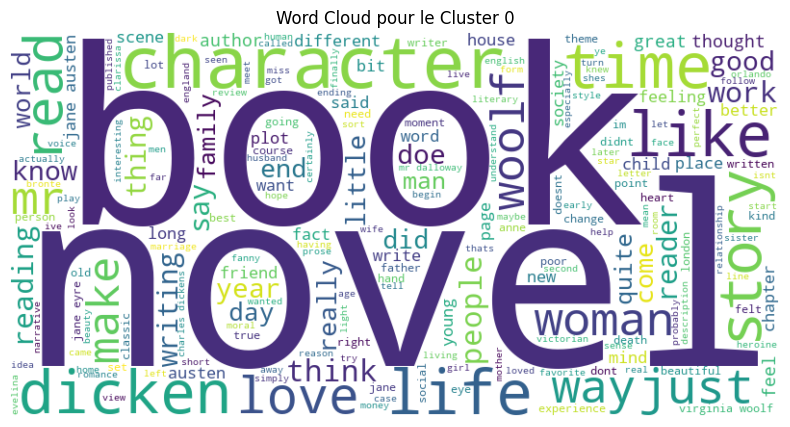

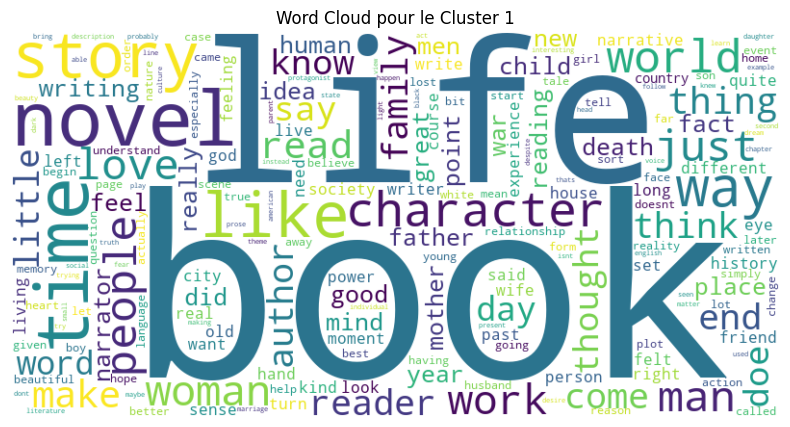

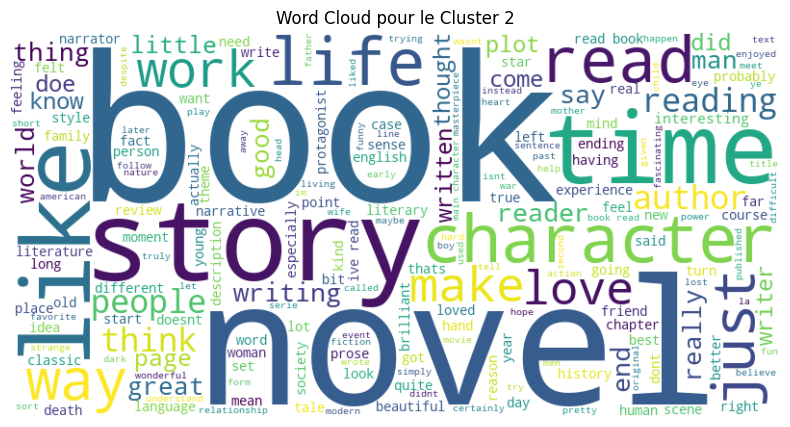

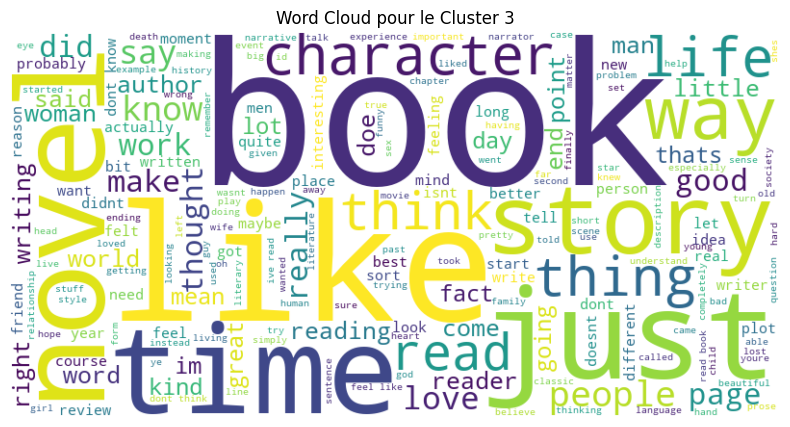

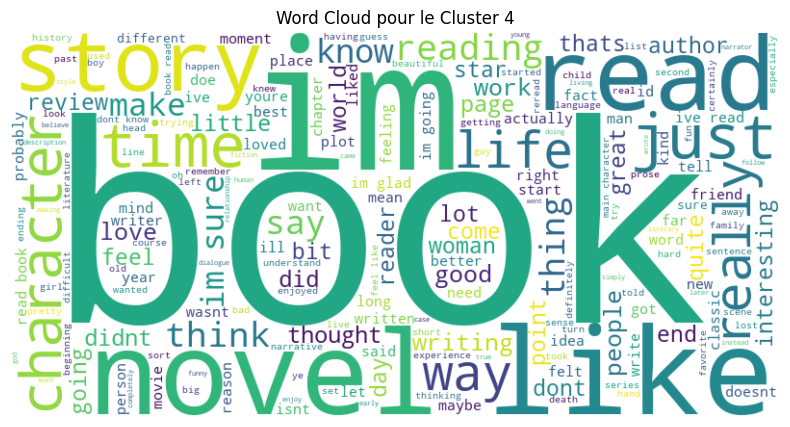

In [37]:
for cluster in sorted(data['cluster'].unique()):
    plot_wordcloud(data, cluster)

INTERPRETATION DES RESULTATS

-> CLUSTER 0 : Auteurs et personnages
On a comme mots dominants : dickens, mr, woolf, jane, austen, virginia, woman, jane austen, virginia woolf, dalloway.
Les avis ici se concentrent sur des auteurs célèbres comme Dickens, Woolf, Austen, et des personnages clés comme Mrs Dalloway.

-> CLUSTER 1 : Thèmes et contexte de l'histoire
On a comme mots dominants : world, woman, man, war, family, people, year, work, young, end.
On y retrouve des thèmes narratifs liés à la guerre, à la famille et à l'histoire. Ce cluster semble regrouper des avis sur des romans d'époque ou historiques.

-> CLUSTER 2 : Appréciation de l'écriture et de l'auteur
On a comme mots dominants : written, work, great, good, interesting, author, year, page, think, end.
Les lecteurs ici jugent l'écriture et l'auteur de manière positive.

-> CLUSTER 3 : Réactions personnelles et critiques
On a comme mots dominants : dont, thing, know, think, people, page, good, didnt, feel, want.
Les avis sont plus personnels et expriment des sentiments directs. On y retrouve des critiques sur le livre.


-> CLUSTER 4
On a comme mots dominants : im, sure, im sure, didnt, ive, glad, im glad, dont, think, know.
Ces mots expriment des sentiments personnels et des opinions directes des lecteurs. Il y a de la conversation, de l'émotion, des réactions personnelles.



In [9]:
data.shape

(23050, 6)

MODELISATION : PREDIRE LE SENTIMENT DU LECTEUR A PARTIR DE SON AVIS

In [10]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

In [11]:
nom_modele = "distilbert-base-uncased-finetuned-sst-2-english"  # modèle pré-entrainé

# le tokenizer transforme le texte en tokens
tokenizer = AutoTokenizer.from_pretrained(nom_modele)

# le modèle est le classificateur de sentiment
model = AutoModelForSequenceClassification.from_pretrained(nom_modele)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\olake\Desktop\PROJETS_CAS_ENTREPRISE\PROJET_1\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\olake\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  55%|#####4    | 147M/268M [00:00<?, ?B/s]

In [12]:
def predict_sentiment(text):
    # Tokenization
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    # Passage dans le modèle
    outputs = model(**inputs)
    # Convertir logits en probabilités
    probs = F.softmax(outputs.logits, dim=-1)
    # Label et score
    label_idx = torch.argmax(probs, dim=1).item()
    score = probs[0, label_idx].item()
    label = model.config.id2label[label_idx]
    return label, score

In [14]:
results = [predict_sentiment(x) for x in data['avis_nettoy']]

data['sentiment_label'] = [r[0] for r in results]
data['sentiment_score'] = [r[1] for r in results]

In [16]:
print(data[['avis_nettoy', 'sentiment_label', 'sentiment_score']].head())
print(data['sentiment_label'].value_counts())

                                         avis_nettoy sentiment_label  \
0  gentle reminder time read book reread 2017 don...        NEGATIVE   
1  60 star know risking film 11 moment club upsid...        NEGATIVE   
2  looking new book dont want commit check latest...        NEGATIVE   
3  pick kill mockingbird instantly visited sensor...        NEGATIVE   
4  longer review written book comment sadly annoy...        NEGATIVE   

   sentiment_score  
0         0.967716  
1         0.959199  
2         0.982205  
3         0.954933  
4         0.987647  
sentiment_label
NEGATIVE    12330
POSITIVE    10720
Name: count, dtype: int64


In [19]:

data.to_csv("C:\\Users\\olake\\Desktop\\PROJETS_CAS_ENTREPRISE\\PROJET_1\\data\\donnees_nettoy\\avis_sentiments.csv", index=False)

In [38]:
pd.crosstab(data["cluster"], data["sentiment_label"], normalize="index") * 100

sentiment_label,NEGATIVE,POSITIVE
cluster,,
0,45.488722,54.511278
1,56.450387,43.549613
2,42.575713,57.424287
3,75.949976,24.050024
4,57.251908,42.748092


In [39]:
# Distribution des sentiments par cluster
sentiment_par_cluster = data.groupby(['cluster', 'sentiment_label']).size().unstack(fill_value=0)
print(sentiment_par_cluster)


sentiment_label  NEGATIVE  POSITIVE
cluster                            
0                     363       435
1                    3715      2866
2                    4344      5859
3                    3158      1000
4                     750       560


In [40]:
# Score moyen par cluster
score_par_cluster = data.groupby('cluster')['sentiment_score'].mean()
print(score_par_cluster)


cluster
0    0.936516
1    0.924072
2    0.946757
3    0.940841
4    0.943509
Name: sentiment_score, dtype: float64


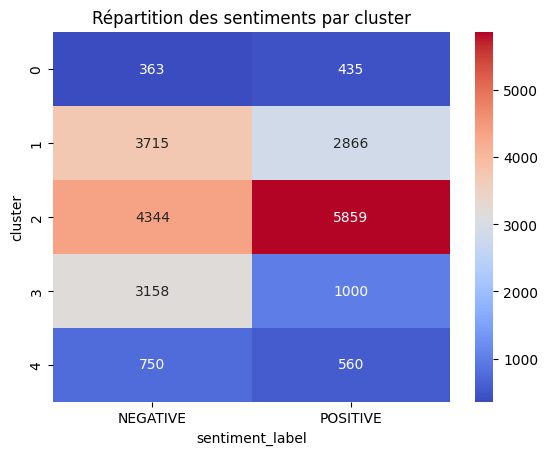

In [41]:
# Heatmap des sentiments par cluster
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(sentiment_par_cluster, annot=True, fmt='d', cmap='coolwarm')
plt.title("Répartition des sentiments par cluster")
plt.show()
